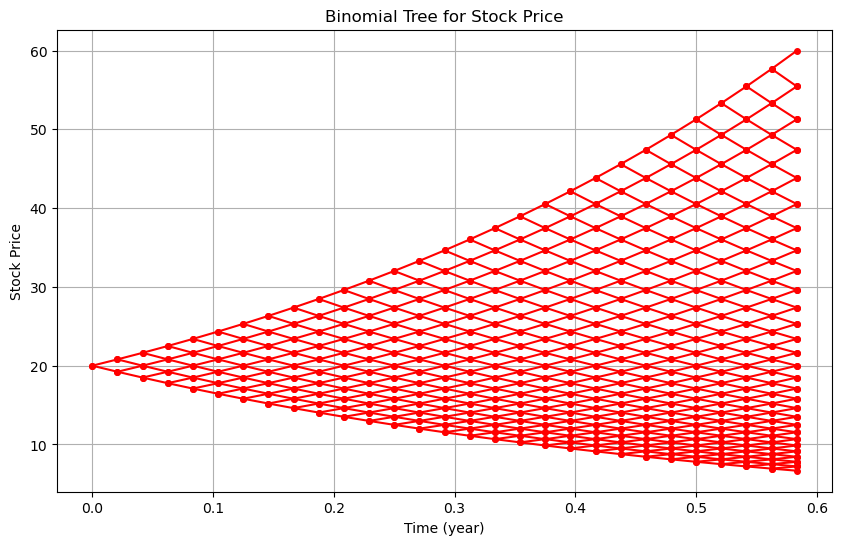

In [11]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Parameters
N = 28  # Number of time periods
T = 7/12  # Total time (in months)
S0 = 20  # Initial stock price
u = 1.04  # Up factor
d = 1 / 1.04  # Down factor
dt = T / N  # Time step

time_points = [0]  # Initialize with time t=0
stock_prices = [[S0]]  # Initialize with initial stock price

# Build the binomial tree
for i in range(N):
    # Calculate the new time and stock price values
    new_time = time_points[-1] + dt
    curr_price = [x*u for x in stock_prices[-1]]
    curr_price.append(curr_price[-1] * d * d)
    
    # Append the new values to the arrays
    time_points.append(new_time)
    stock_prices.append(curr_price)

# Plot the binomial tree
plt.figure(figsize=(10, 6))
for i in range(N):
    curr_points = [x[i] for x in stock_prices[i:]]
    curr_time = time_points[i:]
    plt.plot(curr_time, curr_points, marker='o', linestyle='-', markersize=4, color='r')
for i in range(N):
    curr_points = [x[-i-1] for x in stock_prices[i:]]
    curr_time = time_points[i:]
    plt.plot(curr_time, curr_points, marker='o', linestyle='-', markersize=4, color='r')
plt.title('Binomial Tree for Stock Price')
plt.xlabel('Time (year)')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

In [12]:
# european option
def european_put_binomial(S, K, T, r, q, sigma, N):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r - q) * dt) - d) / (u - d)

    # Build the binomial tree
    option_tree = np.zeros((N + 1, N + 1))
    for j in range(N + 1):
        option_tree[N][j] = max(0, K - S * (u ** (N - j)) * (d ** j))

    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_tree[i][j] = np.exp(-r * dt) * (p * option_tree[i + 1][j] + (1 - p) * option_tree[i + 1][j + 1])

    return option_tree[0][0]

def black_scholes_put(S, K, T, r, q, sigma):

    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

    return option_price

def european_put_BBS(S, K, T, r, q, sigma, N):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r - q) * dt) - d) / (u - d)

    # Build the binomial tree
    option_tree = np.zeros((N, N))
    for j in range(N):
        option_tree[N - 1][j] = black_scholes_put(S * (u ** (N - 1 - j) * (d ** j)), K, dt, r, q, sigma)

    # Backward induction
    for i in range(N - 2, -1, -1):
        for j in range(i + 1):
            option_tree[i][j] = np.exp(-r * dt) * (p * option_tree[i + 1][j] + (1 - p) * option_tree[i + 1][j + 1])

    return option_tree[0][0]

In [15]:
# american option
def american_put_binomial(S, K, T, r, q, sigma, N):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r - q) * dt) - d) / (u - d)

    # Build the binomial tree for the option values
    option_tree = np.zeros((N + 1, N + 1))
    for j in range(N + 1):
        option_tree[N][j] = max(0, K - S * (u ** (N - j)) * (d ** j))

    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            intrinsic = K - S * (u ** (i - j)) * (d ** j)
            option_tree[i][j] = np.maximum(intrinsic, np.exp(-r * dt) * (p * option_tree[i + 1][j] + (1 - p) * option_tree[i + 1][j + 1]))

    return option_tree[0][0]

def american_put_BBS(S, K, T, r, q, sigma, N):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r - q) * dt) - d) / (u - d)

    # Build the binomial tree
    option_tree = np.zeros((N, N))
    for j in range(N):
        intrinsic = K - S * (u ** (N - 1 - j)) * (d ** j)
        option_tree[N - 1][j] = np.maximum(intrinsic, black_scholes_put(S * (u ** (N - 1 - j) * (d ** j)), K, dt, r, q, sigma))

    # Backward induction
    for i in range(N - 2, -1, -1):
        for j in range(i + 1):
            intrinsic = K - S * (u ** (i - j)) * (d ** j)
            option_tree[i][j] = np.maximum(intrinsic, np.exp(-r * dt) * (p * option_tree[i + 1][j] + (1 - p) * option_tree[i + 1][j + 1]))

    return option_tree[0][0]

In [16]:
# parameters
S = 54
K = 50
T = 1
r = 0.0375
q = 0.01
sigma = 0.29

df_eu = pd.DataFrame(index=list(range(10,101)), columns=['bin', 'avg_bin', 'bbs', 'bbsr'])
for N in range(10, 101):
    bin = european_put_binomial(S, K, T, r, q, sigma, N)
    avg_bin = (european_put_binomial(S, K, T, r, q, sigma, N) + european_put_binomial(S, K, T, r, q, sigma, N-1)) / 2
    bbs = european_put_BBS(S, K, T, r, q, sigma, N)
    bbsr = 2 * european_put_BBS(S, K, T, r, q, sigma, N) - european_put_BBS(S, K, T, r, q, sigma, N//2)
    df_eu.loc[N] = [round(bin, 6), round(avg_bin, 6), round(bbs, 6), round(bbsr, 6)]

df_am = pd.DataFrame(index=list(range(10,101)), columns=['bin', 'avg_bin', 'bbs', 'bbsr'])
for N in range(10, 101):
    bin = american_put_binomial(S, K, T, r, q, sigma, N)
    avg_bin = (american_put_binomial(S, K, T, r, q, sigma, N) + american_put_binomial(S, K, T, r, q, sigma, N-1)) / 2
    bbs = american_put_BBS(S, K, T, r, q, sigma, N)
    bbsr = 2 * american_put_BBS(S, K, T, r, q, sigma, N) - american_put_BBS(S, K, T, r, q, sigma, N//2)
    df_am.loc[N] = [round(bin, 6), round(avg_bin, 6), round(bbs, 6), round(bbsr, 6)]

In [17]:
df_eu

,bin,avg_bin,bbs,bbsr
10,3.703631,3.623203,3.617453,3.58382
11,3.512694,3.608162,3.616219,3.581352
12,3.688601,3.600648,3.611436,3.582073
13,3.491921,3.590261,3.610962,3.581125
14,3.675131,3.583526,3.607099,3.580055
...,...,...,...,...
96,3.588529,3.586186,3.583778,3.579312
97,3.582835,3.585682,3.583773,3.579303
98,3.588934,3.585885,3.583683,3.579601
99,3.581835,3.585385,3.583693,3.579622


In [19]:
df_am

,bin,avg_bin,bbs,bbsr
10,3.787176,3.728298,3.701875,3.678494
11,3.635556,3.711366,3.699179,3.673103
12,3.774754,3.705155,3.698507,3.685484
13,3.613913,3.694334,3.694524,3.677519
14,3.763738,3.688826,3.693956,3.676471
...,...,...,...,...
96,3.677469,3.676454,3.673409,3.669471
97,3.674514,3.675992,3.673191,3.669034
98,3.677841,3.676178,3.673307,3.669012
99,3.673592,3.675717,3.673109,3.668618
